In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121


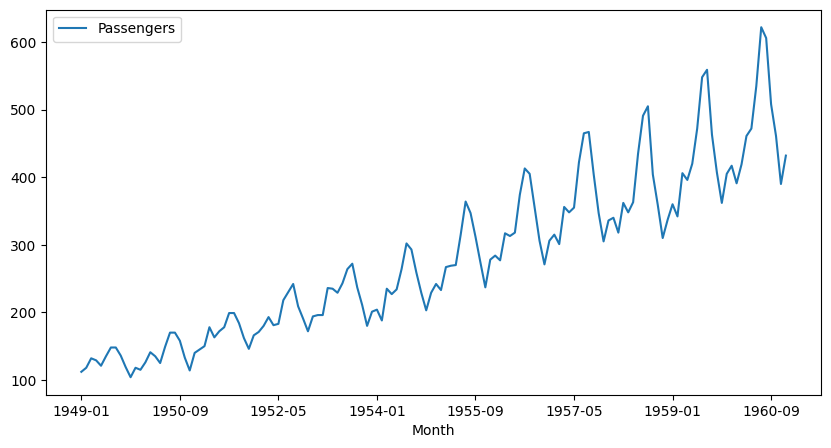

In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(url)

# Visualize the data
print(data.head())
data.plot(x='Month', y='Passengers', figsize=(10, 5))
plt.show()

# Preprocess the data

In [3]:
# Preprocess the data
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Select features and target
features = ['Passengers']
target = 'Passengers'

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])
target_scaler = MinMaxScaler()
data[target] = target_scaler.fit_transform(data[[target]])

# Convert to numpy arrays
X = data[features].values
y = data[target].values

# Create sequences
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 10
X_seq, y_seq = create_sequences(X, y, seq_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Transformer model

Epoch 1/100
6/6 [==============================] - 8s 143ms/step - loss: 1.6955 - val_loss: 0.8369
Epoch 2/100
6/6 [==============================] - 0s 25ms/step - loss: 0.3489 - val_loss: 0.3547
Epoch 3/100
6/6 [==============================] - 0s 26ms/step - loss: 0.2748 - val_loss: 0.1219
Epoch 4/100
6/6 [==============================] - 0s 26ms/step - loss: 0.2188 - val_loss: 0.0521
Epoch 5/100
6/6 [==============================] - 0s 31ms/step - loss: 0.1344 - val_loss: 0.0472
Epoch 6/100
6/6 [==============================] - 0s 28ms/step - loss: 0.1241 - val_loss: 0.0278
Epoch 7/100
6/6 [==============================] - 0s 35ms/step - loss: 0.0978 - val_loss: 0.0184
Epoch 8/100
6/6 [==============================] - 0s 26ms/step - loss: 0.1002 - val_loss: 0.0269
Epoch 9/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0691 - val_loss: 0.0174
Epoch 10/100
6/6 [==============================] - 0s 24ms/step - loss: 0.0818 - val_loss: 0.0359
Epoch 11/100
6/6 [

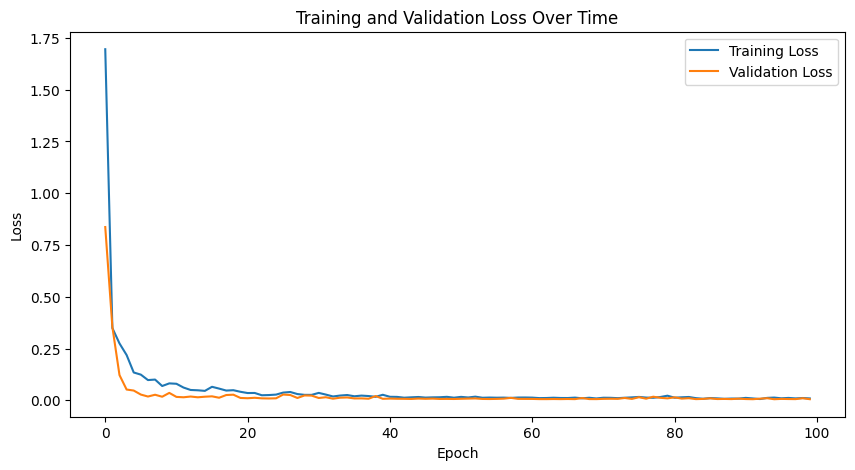

In [4]:
# Define the Transformer model
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(input_shape, embed_dim, num_heads, ff_dim, num_layers):
    inputs = Input(shape=input_shape)
    x = Dense(embed_dim)(inputs)
    for _ in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = Dense(1)(x[:, -1, :])
    model = Model(inputs=inputs, outputs=x)
    return model

# Hyperparameters
input_shape = (seq_length, len(features))
embed_dim = 64
num_heads = 4
ff_dim = 128
num_layers = 2
num_epochs = 100
batch_size = 16
learning_rate = 0.001

# Initialize the model
model = build_transformer_model(input_shape, embed_dim, num_heads, ff_dim, num_layers)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

# Evaluate the model

Test Loss: 0.0035
1/1 [==============================] - 1s 675ms/step


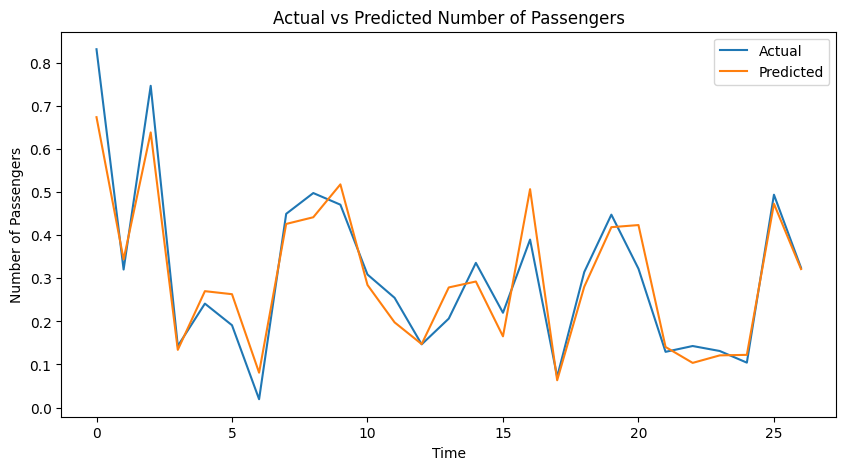

Mean Absolute Percentage Error (MAPE): 26.01%


In [5]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')

# Make predictions
y_test_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred_inv = target_scaler.inverse_transform(y_test_pred)

# Visualize the predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_test_pred_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.title('Actual vs Predicted Number of Passengers')
plt.legend()
plt.show()

# Calculate accuracy (e.g., Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_inv, y_test_pred_inv)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


# If you want to save the model

In [ ]:
model.save('transformer_airline_passengers.h5')

# Full code

In [ ]:
# Load the data
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(url)

# Visualize the data
print(data.head())
data.plot(x='Month', y='Passengers', figsize=(10, 5))
plt.show()

# Preprocess the data
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Select features and target
features = ['Passengers']
target = 'Passengers'

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])
target_scaler = MinMaxScaler()
data[target] = target_scaler.fit_transform(data[[target]])

# Convert to numpy arrays
X = data[features].values
y = data[target].values

# Create sequences
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 10
X_seq, y_seq = create_sequences(X, y, seq_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Define the Transformer model
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(input_shape, embed_dim, num_heads, ff_dim, num_layers):
    inputs = Input(shape=input_shape)
    x = Dense(embed_dim)(inputs)
    for _ in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = Dense(1)(x[:, -1, :])
    model = Model(inputs=inputs, outputs=x)
    return model

# Hyperparameters
input_shape = (seq_length, len(features))
embed_dim = 64
num_heads = 4
ff_dim = 128
num_layers = 2
num_epochs = 100
batch_size = 16
learning_rate = 0.001

# Initialize the model
model = build_transformer_model(input_shape, embed_dim, num_heads, ff_dim, num_layers)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')

# Make predictions
y_test_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred_inv = target_scaler.inverse_transform(y_test_pred)

# Visualize the predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_test_pred_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.title('Actual vs Predicted Number of Passengers')
plt.legend()
plt.show()

# Calculate accuracy (e.g., Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_inv, y_test_pred_inv)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# If you want to save the model
model.save('transformer_airline_passengers.h5')